Brandi Otto

Practicum Final 

December 2023

# I Always Feel Like Somebody's Watching Me
### And I have no Privacy

------------
## What's the Problem?

By the end of 2021 it was estimated that over one billion security cameras would be in use world wide. Around half of those cameras can be found in China, but the United States is not far behind in surveillance cameras per-capita (Cosgrove, 2019). Between government surveillance, private companies, and citizens protecting their own homes, it's become a way of life to assume we are often, if not always being watched. One study finds that in a commute of 29 miles, a US citizen may turn up on as many as 20 cameras and then be filmed an additional 40 times each week around their office (Melore, 2020). I drive mainly interstates and work at the airport, so I can confirm this!

The problem becomes, who monitors these cameras? Do we have enough eyeballs to cover each camera every minute? Do we need help from artificial intelligence? One secutity company polled their customers and found that 15% never even looked at their security footage, instead finding comfort that if a crime was reported, they could rewind (Pro-Vigil, 2022) 

But what if an employee is stealing, the business may not know until they've taken thousands in assets. Or, what if a person is abducted in the back of a warehouse that has unmonitored cameras, the clock is ticking to save that person. When will the victim be reported missing? How long will it take for police to connect that warehouse to them. How long will it take for the warehouse owner to turn over the footage. At that point, how many hours of footage need to be scoured to find the scene?

Can we build a machine learning model that can watch, interpret human actions, and correctly relay that information to authorities?

This is the problem I dove into. 



## Angle of Attack

I obtained a dataset from the University of Central Florida's Center for Research in Computer Vision: https://www.crcv.ucf.edu/projects/real-world/. This dataset contains 1900 videos averaging around 30 seconds each. The videos are classified into 13 labels, ranging from normal activity to burglary to road accidents. This dataset was free to download and was already in MP4 format for processing. 

Because I wanted to build and improve a model, I knew processing time and power would be a concern for all 1.7 million frames. Because of this, I cut the dataset down to just 9 categories: No Crime, Burglary, Explosion, Fighting, Robbery, Shooting, Shoplifting, Stealing, and Vandalism. 
 
I got set loading my data and visualizing it. I wanted to see a histogram of the label categories so that I knew if my dataset would be heavily skewed. It did not appear to be. I then used a column of random numbers in the dataframe to separate the data into train, validation, and test sets. I then extracted the frames while also filtering for frames that were mostly black or white- such as logos at the beginning and end of the video, reshaped and resized frames, preserved the directory so labels could be inferred, and saved the list of frames into a file for later retrieval. I then created a dataset using the frames extracting pixel values and labels. I input them into my chosen model, ConvLSTM2D, and tried to optimize it. 



## What is a ConvLSTM2d layer?

I considered using a classic Convolutional Neural Network for this problem, but I knew that once the frames were split, it would be hard to classify the frames correctly without taking into accout the order that in which the action happened. Because of this, I knew I had to include a time sequence element into the model. The ConvLSTM2D model is the best of both worlds. 

The Convolutional portion of the network uses filters to scroll over the frames to slowly recognize patterns, edges, etc. from the frame. The Long-Short Term Memory portion of the model gives importanceto the action sequence to predict labels on new data. I've seen examples of ConvLSTM2d being used for human action recognition (https://www.youtube.com/watch?v=QmtSkq3DYko) and also movie genre prediction (Xavier, 2019). This seemed like it could do the job.  



## Outcome

Unfortunately, my model accuracy was not what I had hoped. The highest test accuracy that I achieved was 18%. This is slightly better than blindly picking a label. In the end, I let the model run for just under 12 hours with an early stopping patience of 15 trying to overfit the model to see how high I could get the training data. Unfortunately, the validation accuracy on that stalled, and the overfiting was not impressive. I wasn't convinced the model could learn more from the training data in its current state.

I attribute my poor model performance to a few things:

- I believe that the videos are not focused enough on the specific action of the label. I think the best idea would be to trim the videos, however, I am not sure how to do that unless it's done manually. 

-  I think that the categories, while logical for my problem statement, are too similar. Burglary, robbery, stealing, and shoplifting probably look alot alike. Those categories could be combined and compared against the no crime videos for a more realistic model. Combining them and leaving the rest as is would result in a very skewed dataset. 

- It could be the wrong model for the situation. A more basic lstm model may have performed better. 

 Weirdly, when I checked the predictions being made for the last model, it was predicting only one class. This is strange because the label being predicted was not the highest occuring in the histogram- it was among the lowest. The model was not skewed towards that class. I do not yet haave an explanation for this. 


## Where Can I take this in the future?

- Once the video was trimmed, I'd increase the sequence length so that it could better capture the action.

- Once the videos are trimmed and the sequence length increases, I'd check the current model to see if the confusion matrix looks more realistic or if one label is still being predicted. 

- Lastly, I'd like to try running a time distributed version of the ResNet50 pretrained model. I do believe that this kind of problem can benefit from a pretrained model bringing all of its knowledge. However, the input shape for this model was different than the one that I was working with, and in the time allotted, I was not able to jump back to the beginning to change my frame preprocess steps to run the ResNet50 model, as I had hoped. I think this, combined with heavy video editing could give the accuracy a considerable bump. 

- The end goal would be to develop a real world model that has high training accuracy that is light enough to run locally, even for a mid-size business. I'd like to give them the freedom to self monitor without having to pay a company. 




--------------

In [28]:
# Load libraries

import os
import cv2
import math
import random
import pandas as pd
import numpy as np
import shutil
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend, models, layers, optimizers, regularizers
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, ConvLSTM2D, MaxPooling3D, TimeDistributed
from tensorflow.keras.optimizers import Adam

The code above loads libraries. 

The code below sets the seed so that anything random in this project can be replicated. 

In [29]:
seed_constant = 42
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

The code below separates the files into train/valid/test folders using random number and os.shutil.

In [33]:
def list_mp4_files(directory): #this will walk through the directory to pull all the mp4 files and put them into a list so that I can create a dataframe
    mp4_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(".mp4"):
                mp4_files.append(os.path.join(root, file))
    return mp4_files

# where are my files
directory_path = "all_videos"
mp4_files_list = list_mp4_files(directory_path)

# Print the list of mp4 files
for mp4_file in mp4_files_list:
    print(mp4_file)


all_videos/valid/9/Stealing095_x264.mp4
all_videos/valid/9/Stealing105_x264.mp4
all_videos/valid/9/Stealing045_x264.mp4
all_videos/valid/9/Stealing108_x264.mp4
all_videos/valid/9/Stealing102_x264.mp4
all_videos/valid/9/Stealing016_x264.mp4
all_videos/valid/9/Stealing055_x264.mp4
all_videos/valid/9/Stealing031_x264.mp4
all_videos/valid/9/Stealing030_x264.mp4
all_videos/valid/9/Stealing050_x264.mp4
all_videos/valid/9/Stealing013_x264.mp4
all_videos/valid/9/Stealing081_x264.mp4
all_videos/valid/9/Stealing074_x264.mp4
all_videos/valid/0/Normal_Videos_352_x264.mp4
all_videos/valid/0/Normal_Videos_310_x264.mp4
all_videos/valid/0/Normal_Videos_050_x264.mp4
all_videos/valid/0/Normal_Videos_798_x264.mp4
all_videos/valid/0/Normal_Videos_603_x264.mp4
all_videos/valid/0/Normal_Videos_621_x264.mp4
all_videos/valid/0/Normal_Videos_656_x264.mp4
all_videos/valid/0/Normal_Videos_150_x264.mp4
all_videos/valid/7/Shooting001_x264.mp4
all_videos/valid/7/Shooting043_x264.mp4
all_videos/valid/7/Shooting025_x

 I've ran this code above again since the beginning- it shouldn't include the train/validation/test subdirectories the first time through
 
 Make the directories.

In [4]:
os.makedirs('all_videos/train')
os.makedirs('all_videos/valid')
os.makedirs('all_videos/test')

Turn the list of mp4's to a dataframe and add random numbers in a new column between 0 and 100. Move all numbers 70 and down to the train folder, 71 to 85 to validation, and 86 to 100 to test folders.

In [35]:

df = pd.DataFrame(mp4_files_list)

df

,0
0,all_videos/valid/9/Stealing095_x264.mp4
1,all_videos/valid/9/Stealing105_x264.mp4
2,all_videos/valid/9/Stealing045_x264.mp4
3,all_videos/valid/9/Stealing108_x264.mp4
4,all_videos/valid/9/Stealing102_x264.mp4
...,...
645,all_videos/train/2/Burglary100_x264.mp4
646,all_videos/train/2/Burglary009_x264.mp4
647,all_videos/train/2/Burglary040_x264.mp4
648,all_videos/train/2/Burglary037_x264.mp4


In [37]:
data = np.random.randint(0,100,size=650)

df['randnum'] = data
df

,0,randnum
0,all_videos/valid/9/Stealing095_x264.mp4,7
1,all_videos/valid/9/Stealing105_x264.mp4,39
2,all_videos/valid/9/Stealing045_x264.mp4,82
3,all_videos/valid/9/Stealing108_x264.mp4,41
4,all_videos/valid/9/Stealing102_x264.mp4,40
...,...,...
645,all_videos/train/2/Burglary100_x264.mp4,24
646,all_videos/train/2/Burglary009_x264.mp4,83
647,all_videos/train/2/Burglary040_x264.mp4,4
648,all_videos/train/2/Burglary037_x264.mp4,64


In [38]:
df.columns

Index([0, 'randnum'], dtype='object')

Rename the dataframe column for the video file paths to video

In [39]:
df.rename( columns={0 :'video'}, inplace=True )

In [ ]:
#the first 5 letters of the name of the mp4 file can be pulled from the dataframe column and turned into a label

df.label = df.video.str[0:5]

df

Make the labels into numbers for easier processing later.

In [ ]:
df['label'].replace('Arres', 1, inplace=True)
df['label'].replace('Burgl', 2, inplace=True)
df['label'].replace('Explo', 3, inplace=True)
df['label'].replace('Fight', 4, inplace=True)
df['label'].replace('Robbe', 6, inplace=True)
df['label'].replace('Shoot', 7, inplace=True)
df['label'].replace('Shopl', 8, inplace=True)
df['label'].replace('Steal', 9, inplace=True)
df['label'].replace('Vanda', 10, inplace=True)
df['label'].replace('Norma', 0, inplace=True)


In [ ]:
df['label'].unique()

Make the new directories for the train, valid, and test video files to be moved to.

In [ ]:
folderpath = 'all_videos/train'
folderlist = ['0', '2', '3', '4', '6', '7', '8', '9', '10']

for items in folderlist:
    path = os.path.join(folderpath, items)
    os.mkdir(path)

In [ ]:
folderpath = 'all_videos/valid'
folderlist = ['0', '2', '3', '4', '6', '7', '8', '9', '10']

for items in folderlist:
    path = os.path.join(folderpath, items)
    os.mkdir(path)

In [ ]:
folderpath = 'all_videos/test'
folderlist = ['0', '2', '3', '4', '6', '7', '8', '9', '10']

for items in folderlist:
    path = os.path.join(folderpath, items)
    os.mkdir(path)

Move the video files to their new folders under train, valid, and test.

In [ ]:
for index, row in df.iterrows():
  if row['randnum'] in range(0,80) :
    shutil.move('all_videos/' + str(row['video']), 'all_videos/train/' + str(row['label']))
  elif row['randnum'] in range (81,90):
    shutil.move('all_videos/' + str(row['video']), 'all_videos/valid/' + str(row['label']))
  else:
    shutil.move('all_videos/' + str(row['video']), 'all_videos/test/' + str(row['label']))

I will save the dataframe to csv incase I need it later. 

In [ ]:
df.to_csv('videos_with_labels.csv')

In [42]:
df = pd.read_csv("videos_with_labels.csv")
df

,Unnamed: 0,video,label,randnum
0,0,Vandalism016_x264.mp4,10,94
1,1,Vandalism017_x264.mp4,10,97
2,2,Arrest008_x264.mp4,1,99
3,3,Explosion041_x264.mp4,3,62
4,4,Arrest009_x264.mp4,1,33
...,...,...,...,...
995,996,Abuse042_x264.mp4,12,40
996,997,Shoplifting037_x264.mp4,8,98
997,998,Assault032_x264.mp4,11,58
998,999,Normal_Videos_248_x264.mp4,0,18


In [55]:
#the dataframe was created with all labels still in tact. I will filter them out now. 
unused_labels = df[(df['label'] == 0) & (df['label'] == 2) & (df['label'] == 3) & (df['label'] == 4) & (df['label'] == 6) & (df['label'] == 7) & (df['label'] == 8) &
         (df['label'] == 9) & (df['label'] == 10)].index

df.drop(unused_labels, inplace=True)
df.head(20)


,Unnamed: 0,video,label,randnum
0,0,Vandalism016_x264.mp4,10,94
1,1,Vandalism017_x264.mp4,10,97
2,2,Arrest008_x264.mp4,1,99
3,3,Explosion041_x264.mp4,3,62
4,4,Arrest009_x264.mp4,1,33
5,5,Explosion040_x264.mp4,3,52
6,6,Stealing011_x264.mp4,9,11
7,7,Stealing010_x264.mp4,9,80
8,8,Robbery049_x264.mp4,6,30
9,9,Robbery048_x264.mp4,6,84


Below, the histogram shows the spread of number of videos for each category. It looks as though Robbery(6) videos has twice as many as some. 

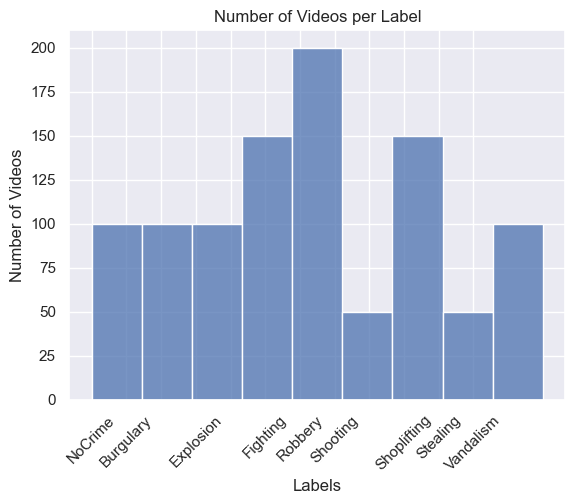

In [101]:
import seaborn as sns

sns.set(style="darkgrid")


a = sns.histplot(df, x="label", bins=9)
a.set_xticks(range(12))
a.set_xticklabels(['NoCrime', 'Burgulary', '','Explosion', '','Fighting', 'Robbery', 'Shooting', '','Shoplifting', 'Stealing', 'Vandalism'])
plt.xticks(rotation=45) 
plt.title("Number of Videos per Label")
plt.ylabel("Number of Videos")
plt.xlabel("Labels")


plt.show()


------------

## Now that the files are separated into train, valid, and test folders, lets get into it!

The concept and structure of the project was based on the tutorial from Bleed AI Academy. Code was heavily adapted to fit the purposes of this project.
https://www.youtube.com/watch?v=QmtSkq3DYko

Below, I will set all of the info needed for extracting, cleaning and storing frames. 

In [3]:
image_height, image_width = 224, 224

sequence_length = 30 #number of videos extracted per video- at an equal distance throughout

input_directory_train = 'all_videos/train' 
input_directory_valid = 'all_videos/valid'
input_directory_test = 'all_videos/test'

class_list = '0','2','3','4', '6','7','8', '9','10'

output_directory_train = 'all_videos/train/output'
output_directory_valid = 'all_videos/valid/output'
output_directory_test = 'all_videos/test/output'

threshold = .65

target_size = (224,224)

The next three blocks of code will extract frames from the .mp4 video files. It will filter the frames to make sure they are not more than 65% black or 65% white because some of the videos start/end with a few seconds of solid (or almost solid) frames that do not relate to the dataset. If they are over the threshold, the code will grab a new frame to replace it .8 seconds later in the video. I didn't want the frames being extracted to run into each other. The code extracts 30 frames per video in the dataset. They are equally spaced throughout the video, unless the frame needed replaced.

It then resizes and normalizes the frames for better results later. The frames are then saved for later use.

In the next section, a dataset is created from the extracted image features (into a numpy array), labels, and paths to videos. Since OpenCV2 uses BGR color channels, this code also converts them back to RGB.

# Train dataset

In [4]:
#this function sets the threshold to remove mostly black or white frames
def is_mostly_black_or_white(image, threshold=0.65):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #converts to greyscale
    black_percentage = np.sum(gray_image == 0) / gray_image.size #checks amount black pixels
    white_percentage = np.sum(gray_image == 255) / gray_image.size #checks amount white pixels
    return black_percentage > threshold or white_percentage > threshold

def frames_extraction(video_path, output_directory_train, sequence_length=30, image_height=224, image_width=224):
    frame_paths1 = []

    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT)) #figures out frame count to equally extract 30 frames

    skip_frames_window = max(int(video_frames_count / sequence_length), 1)

    # Extracts the original file name without extension
    video_name, _ = os.path.splitext(os.path.basename(video_path))

    for frame_counter in range(sequence_length):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        # Checks if the frame passes the threshold filter
        if is_mostly_black_or_white(frame, threshold):  
            # If over the threshold, replace with a frame from 0.8 seconds later
            replacement_frame_counter = int((frame_counter + 0.8) * skip_frames_window)
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, replacement_frame_counter)
            success, replacement_frame = video_reader.read()
            if success:
                frame = replacement_frame

        resized_frame = cv2.resize(frame, (image_height, image_width))

        # Save the frame using imwrite in an output_directory preserving the subdirectory structures
        output_subdir = os.path.join(output_directory_train, os.path.dirname(video_name))
        os.makedirs(output_subdir, exist_ok=True)

        #make a list of frames and save it for later use in case kernel crashes or restarts
        output_frame_path1 = os.path.join(output_subdir, f"{video_name}_frame_{frame_counter}.jpg")
        cv2.imwrite(output_frame_path1, resized_frame)
        frame_paths1.append(output_frame_path1)

    video_reader.release()

    return frame_paths1




Above, sets how the frames will extract.
Below, runs the frame extraction code and saves the frame_paths list to a txt file in case this notebook crashes and needs to be pulled back.

In [5]:
all_frame_paths1 = []  # start empty list of frames

for root, dirs, files in os.walk(input_directory_train): # walks through directory to grab mp4 files and run through frame extraction function
    for file in files:
        if file.endswith(".mp4"):
            video_path = os.path.join(root, file)

            # Preserve the directory structure in the output directory
            relative_path = os.path.relpath(video_path, input_directory_train)
            output_subdir = os.path.join(output_directory_train, os.path.dirname(relative_path))
            os.makedirs(output_subdir, exist_ok=True)

            # Extract the frames with function
            frame_paths1 = frames_extraction(video_path, output_subdir, sequence_length)

            # Append frame paths to the list
            all_frame_paths1.extend(frame_paths1)

# Save all_frame_paths to a single text file for later use 1 is for train data, 2 for valid, 3 for test
txt_file_path = os.path.join(output_directory_train, 'all_frame_paths1.txt')
with open(txt_file_path, 'w') as file:
    file.write('\n'.join(all_frame_paths1))

print(f"All frame paths saved to {txt_file_path}")

All frame paths saved to all_videos/train/output/all_frame_paths1.txt


In [6]:
#check how many frames were extracted
len(all_frame_paths1) 

15300

In [7]:
#this function takes the output from above to create a dataset with the output shape set up for the ConvLSTM2D models below
def create_dataset(input_directory_train, output_directory_train, class_list, sequence_length=30):
    features1 = []
    labels1 = []
    video_files_paths1 = []

    for class_index, class_name in enumerate(class_list): #extracts labels
        print(f'Extracting Data of Class:', class_name)

        class_dir = os.path.join(input_directory_train, class_name) #joins frames and labels
        output_class_dir = os.path.join(output_directory_train, class_name)

        files_list = os.listdir(class_dir)

        for file_name in files_list:
            video_file_path = os.path.join(class_dir, file_name)

            if len(frame_paths1) == sequence_length:
                # Read frames using cv2.imread and convert BGR to RGB
                frames = [cv2.cvtColor(cv2.imread(frame_path), cv2.COLOR_BGR2RGB) for frame_path in frame_paths1]

                features1.append(frames) #append each new frame
                labels1.append(class_index) #append each new label
                video_files_paths1.append(video_file_path) #append each new path

    features1 = np.asarray(features1) #np.array is pixel value format needed for model
    labels1 = np.array(labels1)

    return features1, labels1, video_files_paths1


features1, labels1, video_files_paths1 = create_dataset(input_directory_train, output_directory_train, class_list, sequence_length)

# Print the shape of the image features array - double check the shape is correct for model
print("Image Features Shape:", features1.shape)

# Print the unique labels
print("Labels:", np.unique(labels1))

Extracting Data of Class: 0
Extracting Data of Class: 2
Extracting Data of Class: 3
Extracting Data of Class: 4
Extracting Data of Class: 6
Extracting Data of Class: 7
Extracting Data of Class: 8
Extracting Data of Class: 9
Extracting Data of Class: 10
Image Features Shape: (511, 30, 224, 224, 3)
Labels: [0 1 2 3 4 5 6 7 8]


# Valid Dataset

Repeat blocks of code used on train data. 

In [8]:
def is_mostly_black_or_white(image, threshold=0.65):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    black_percentage = np.sum(gray_image == 0) / gray_image.size
    white_percentage = np.sum(gray_image == 255) / gray_image.size
    return black_percentage > threshold or white_percentage > threshold

def frames_extraction(video_path, output_directory_valid, sequence_length=30, image_height=224, image_width=224):
    frame_paths2 = []

    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count / sequence_length), 1)

    # Extract the original name without extension
    video_name, _ = os.path.splitext(os.path.basename(video_path))

    for frame_counter in range(sequence_length):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        # Check if the frame passes the threshold filter
        if is_mostly_black_or_white(frame, threshold):  # Use the BGR frame for threshold check
            # If over the threshold, replace with a frame from 0.8 seconds later
            replacement_frame_counter = int((frame_counter + 0.8) * skip_frames_window)
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, replacement_frame_counter)
            success, replacement_frame = video_reader.read()
            if success:
                frame = replacement_frame

        resized_frame = cv2.resize(frame, (image_height, image_width))

        # Save the frame using imwrite in an output_directory preserving the structure
        output_subdir = os.path.join(output_directory_valid, os.path.dirname(video_name))
        os.makedirs(output_subdir, exist_ok=True)

        output_frame_path2 = os.path.join(output_subdir, f"{video_name}_frame_{frame_counter}.jpg")
        cv2.imwrite(output_frame_path2, resized_frame)
        frame_paths2.append(output_frame_path2)

    video_reader.release()

    return frame_paths2




In [9]:
all_frame_paths2 = []  

for root, dirs, files in os.walk(input_directory_valid):
    for file in files:
        if file.endswith(".mp4"):
            video_path = os.path.join(root, file)

            # Preserve the directory structure in the output directory
            relative_path = os.path.relpath(video_path, input_directory_valid)
            output_subdir = os.path.join(output_directory_valid, os.path.dirname(relative_path))
            os.makedirs(output_subdir, exist_ok=True)

            # Extract frames
            frame_paths2 = frames_extraction(video_path, output_subdir, sequence_length)

            # Append frame paths to the list
            all_frame_paths2.extend(frame_paths2)

# Save all_frame_paths to a single text file
txt_file_path = os.path.join(output_directory_valid, 'all_frame_paths2.txt')
with open(txt_file_path, 'w') as file:
    file.write('\n'.join(all_frame_paths2))

print(f"All frame paths saved to {txt_file_path}")

All frame paths saved to all_videos/valid/output/all_frame_paths2.txt


In [10]:
len(all_frame_paths2)

1860

In [11]:
def create_dataset(input_directory_valid, output_directory_valid, class_list, sequence_length=30):
    features2 = []
    labels2 = []
    video_files_paths2 = []

    for class_index, class_name in enumerate(class_list):
        print(f'Extracting Data of Class:', class_name)

        class_dir = os.path.join(input_directory_valid, class_name)
        output_class_dir = os.path.join(output_directory_valid, class_name)

        files_list = os.listdir(class_dir)

        for file_name in files_list:
            video_file_path = os.path.join(class_dir, file_name)

            if len(frame_paths2) == sequence_length:
                # Read frames using cv2.imread and convert BGR to RGB
                frames = [cv2.cvtColor(cv2.imread(frame_path), cv2.COLOR_BGR2RGB) for frame_path in frame_paths2]

                features2.append(frames)
                labels2.append(class_index)
                video_files_paths2.append(video_file_path)

    features2 = np.asarray(features2)
    labels2 = np.array(labels2)

    return features2, labels2, video_files_paths2


features2, labels2, video_files_paths2 = create_dataset(input_directory_valid, output_directory_valid, class_list, sequence_length)

# Print the shape of the image features array
print("Image Features Shape:", features2.shape)

# Print the unique labels
print("Labels:", np.unique(labels2))

Extracting Data of Class: 0
Extracting Data of Class: 2
Extracting Data of Class: 3
Extracting Data of Class: 4
Extracting Data of Class: 6
Extracting Data of Class: 7
Extracting Data of Class: 8
Extracting Data of Class: 9
Extracting Data of Class: 10
Image Features Shape: (63, 30, 224, 224, 3)
Labels: [0 1 2 3 4 5 6 7 8]


# Test Dataset

Repeat the same code used on the train and valid data

In [12]:
def is_mostly_black_or_white(image, threshold=0.65):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    black_percentage = np.sum(gray_image == 0) / gray_image.size
    white_percentage = np.sum(gray_image == 255) / gray_image.size
    return black_percentage > threshold or white_percentage > threshold

def frames_extraction(video_path, output_directory_test, sequence_length=30, image_height=224, image_width=224):
    frame_paths3 = []

    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count / sequence_length), 1)

    # Extract the original name without extension
    video_name, _ = os.path.splitext(os.path.basename(video_path))

    for frame_counter in range(sequence_length):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        # Check if the frame passes the threshold filter
        if is_mostly_black_or_white(frame, threshold):  
            # If over the threshold, replace with a frame from 0.8 seconds later
            replacement_frame_counter = int((frame_counter + 0.8) * skip_frames_window)
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, replacement_frame_counter)
            success, replacement_frame = video_reader.read()
            if success:
                frame = replacement_frame

        resized_frame = cv2.resize(frame, (image_height, image_width))

        # Save the frame using imwrite in an output_directory preserving the structure
        output_subdir = os.path.join(output_directory_test, os.path.dirname(video_name))
        os.makedirs(output_subdir, exist_ok=True)

        output_frame_path3 = os.path.join(output_subdir, f"{video_name}_frame_{frame_counter}.jpg")
        cv2.imwrite(output_frame_path3, resized_frame)
        frame_paths3.append(output_frame_path3)

    video_reader.release()

    return frame_paths3

In [13]:
all_frame_paths3 = []  # Initialize a list to store frame paths from all videos

for root, dirs, files in os.walk(input_directory_test):
    for file in files:
        if file.endswith(".mp4"):
            video_path = os.path.join(root, file)

            # Preserve the directory structure in the output directory
            relative_path = os.path.relpath(video_path, input_directory_test)
            output_subdir = os.path.join(output_directory_test, os.path.dirname(relative_path))
            os.makedirs(output_subdir, exist_ok=True)

            # Extract frames
            frame_paths3 = frames_extraction(video_path, output_subdir, sequence_length)

            # Append frame paths to the list
            all_frame_paths3.extend(frame_paths3)

# Save all_frame_paths to a single text file
txt_file_path = os.path.join(output_directory_test, 'all_frame_paths3.txt')
with open(txt_file_path, 'w') as file:
    file.write('\n'.join(all_frame_paths3))

print(f"All frame paths saved to {txt_file_path}")

All frame paths saved to all_videos/test/output/all_frame_paths3.txt


In [14]:
len(all_frame_paths3)

2340

In [15]:
def create_dataset(input_directory_test, output_directory_test, class_list, sequence_length=30):
    features3 = []
    labels3 = []
    video_files_paths3 = []

    for class_index, class_name in enumerate(class_list):
        print(f'Extracting Data of Class:', class_name)

        class_dir = os.path.join(input_directory_test, class_name)
        output_class_dir = os.path.join(output_directory_test, class_name)

        files_list = os.listdir(class_dir)

        for file_name in files_list:
            video_file_path = os.path.join(class_dir, file_name)

            if len(frame_paths3) == sequence_length:
                # Read frames using cv2.imread and convert BGR to RGB
                frames = [cv2.cvtColor(cv2.imread(frame_path), cv2.COLOR_BGR2RGB) for frame_path in frame_paths3]

                features3.append(frames)
                labels3.append(class_index)
                video_files_paths3.append(video_file_path)

    features3 = np.asarray(features3)
    labels3 = np.array(labels3)

    return features3, labels3, video_files_paths3


features3, labels3, video_files_paths3 = create_dataset(input_directory_test, output_directory_test, class_list, sequence_length)

# Print the shape of the image features array
print("Image Features Shape:", features3.shape)

# Print the unique labels
print("Labels:", np.unique(labels3))

Extracting Data of Class: 0
Extracting Data of Class: 2
Extracting Data of Class: 3
Extracting Data of Class: 4
Extracting Data of Class: 6
Extracting Data of Class: 7
Extracting Data of Class: 8
Extracting Data of Class: 9
Extracting Data of Class: 10
Image Features Shape: (78, 30, 224, 224, 3)
Labels: [0 1 2 3 4 5 6 7 8]


Now, the frames are clean and ready to use in the model. 

## Visualize frames from the dataset. 
As a reminder 0 = No Crime, 2 = Burglary, 3 = Explosion, 4 = Fighting, 6 = Robbery, 7 = Shooting, 8 = Shoplifting, 9 = Stealing, 10 = Vandalism. 

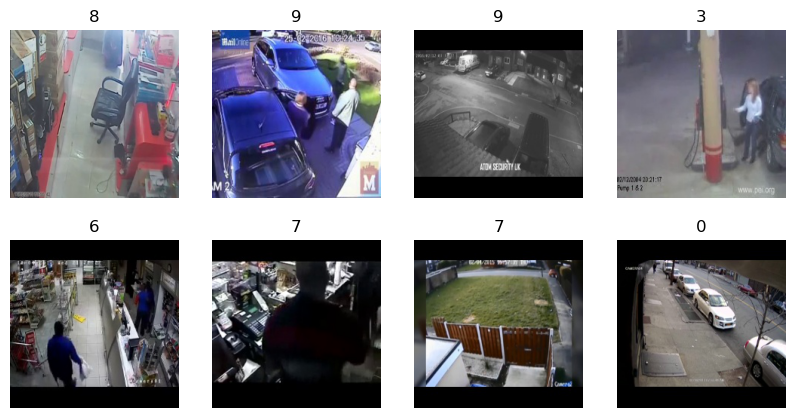

In [16]:
#this code will grab 8 random images with their labels from the directory path given

def display_random_images(directory, num_images=8, image_size=(80, 80)):
    # List all files in the directory
    all_files = [] #empty list
    for root, _, files in os.walk(directory): #walks through directory to find .jpg images
        for file in files:
            if file.lower().endswith('.jpg'):
                all_files.append(os.path.join(root, file))

    if not all_files:
        print("No JPG files found in the directory.")
        return

    # Select 8 random images from the list
    random_images = random.sample(all_files, min(num_images, len(all_files)))

    # Display the images in 2x4 configuration
    rows, cols = 2, 4
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5))

    for i, ax in enumerate(axes.flat):
        if i < len(random_images):
            img_path = random_images[i]
            img = Image.open(img_path)
            img = img.resize(image_size)
            ax.imshow(img)
            ax.axis('off')

            # Extract folder name from the path and use it as the label
            label = os.path.basename(os.path.dirname(img_path))
            ax.set_title(label)
        else:
            ax.axis('off')

    plt.show()

selected_directory = 'all_videos/train/output' 

if os.path.exists(selected_directory):
    display_random_images(selected_directory, num_images=8, image_size=(224, 224))

### Above, it is clear that without the LSTM portion of the model, it would be impossible to classify these images correctly. 

Use the to_categorical function to ensure the labels are in the correct format. It creates 9 different columns with 0 for all columns that do not match the label and 1 is the correct label. 

In [17]:
one_hot_encoded_labels1 = to_categorical(labels1)
one_hot_encoded_labels2 = to_categorical(labels2)
one_hot_encoded_labels3 = to_categorical(labels3)

Create plots for the loss and accuracy during training. This helps make sure the model is not just memorizing the training data with the validation data plot points.

Code modified from Deep Learning Summer 2023 Class

In [18]:
def plot_history(history):
  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  acc_values = history_dict['accuracy']
  val_acc_values = history_dict['val_accuracy']
  epochs = range(1, len(history_dict['accuracy']) + 1)

  plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
  plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
  plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  return plt.show()

## Model #1:

Model 1 will start simply with 4 then 8 filters. I'm using dropout so that the model doesn't see all of the data each time. The layers are then flattened and put through a dense layer that is fully connected with 9 output options and an activaiton of softmax for multiple labels. The padding in the pooling layer will ensure that the outside pixels are counted the same number of times as the inside pixels which I thought was important because crime can occur at the edges of the image- especially if the criminal knows there is a camera present and is trying to evade. 

In [20]:
def CNNLSTM_model():

    backend.clear_session()

    model = Sequential()

    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='relu', data_format='channels_last', recurrent_dropout=0.2,
                         return_sequences=True, input_shape=(sequence_length, image_height, image_width, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2))) 

    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='relu', data_format='channels_last',
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(9, activation='softmax'))

    model.summary()

    return model


In [21]:
model = CNNLSTM_model()

print('Model Created Successfully!')

2023-11-29 03:10:43.013428: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 30, 222, 222, 4)   1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 30, 111, 111, 4)  0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 30, 111, 111, 4)  0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 30, 109, 109, 8)   3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 30, 55, 55, 8)    0         
 3D)                                                             
                                                        

I set the batch size to 10. I started it out at 30, but even the GPU on Google Colab could not handle that. I wanted to try the shuffle on False because I did not want to mix up the order of the frames. I set the patience to 5 so that if 5 epochs in a row the validation loss decreased, the model would stop. 

In [22]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5)

model.compile(loss= 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

history = model.fit(x = features1, y= one_hot_encoded_labels1, epochs = 20,
                    batch_size = 10, shuffle = False, validation_data = (features2, one_hot_encoded_labels2),
                    callbacks = [early_stopping_callback])

Epoch 1/20
52/52 [==============================] - 1016s 19s/step - loss: 44048.2188 - accuracy: 0.3640 - val_loss: 62633.8438 - val_accuracy: 0.2063
Epoch 2/20
52/52 [==============================] - 999s 19s/step - loss: 60033.6289 - accuracy: 0.1820 - val_loss: 46857.3320 - val_accuracy: 0.2063
Epoch 3/20
52/52 [==============================] - 996s 19s/step - loss: 58390.3398 - accuracy: 0.0861 - val_loss: 35935.3164 - val_accuracy: 0.2063
Epoch 4/20
52/52 [==============================] - 1021s 20s/step - loss: 44849.2539 - accuracy: 0.1996 - val_loss: 51254.1562 - val_accuracy: 0.2063
Epoch 5/20
52/52 [==============================] - 979s 19s/step - loss: 54168.7188 - accuracy: 0.1096 - val_loss: 70551.7266 - val_accuracy: 0.2063
Epoch 6/20
52/52 [==============================] - 992s 19s/step - loss: 54962.7617 - accuracy: 0.0783 - val_loss: 66263.2344 - val_accuracy: 0.2063
Epoch 7/20
52/52 [==============================] - 978s 19s/step - loss: 47860.5898 - accuracy: 0

In [25]:
test_loss, test_acc =model.evaluate(x = features3, y = one_hot_encoded_labels3, steps = 30, verbose=1) 


30/30 [==============================] - 31s 1s/step - loss: 123457.5156 - accuracy: 0.2051


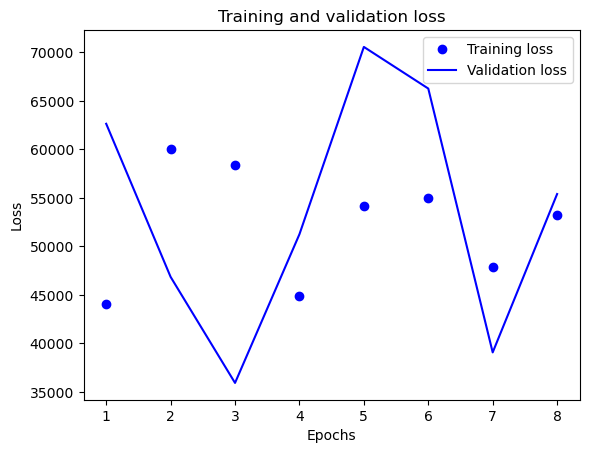

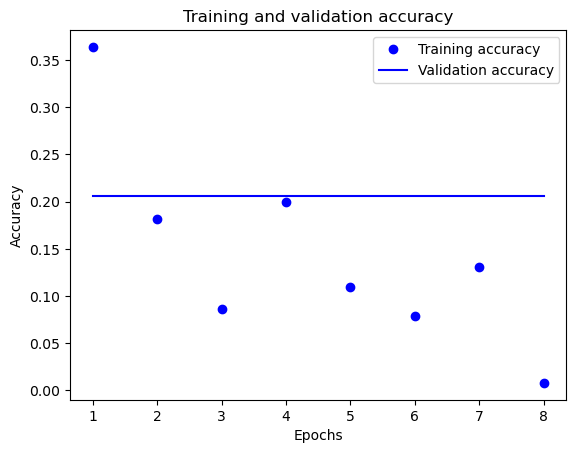

In [26]:
plot_history(history)

## Model #1 Summary:

Model 1 stopped after only 8 epochs. The training accuracy started over 35% but ended under 1%, but the validation accuracy was 20.63% in every epoch, which seemed fishy. The plots showed that my training and validation data was all over the place. 

For tuning, I'll focus on Batch Size, Epochs, and filters, as suggested by Jason Brownlee(Brownlee, 2020) for time series forecasting. 


## Model #2:

Next, I will try making the model more intricate by increaseing filters while decreasing the batch size to lessen the load on the memory. 

I'm wondering if my validation accuracy looks like that because I didn't shuffle the data? - not changing yet. 

Also, I'm changing the early stopping patience to 3 to speed things up. 

In [27]:
def CNNLSTM_model2():

    backend.clear_session()

    model = Sequential()

    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='relu', data_format='channels_last', recurrent_dropout=0.2,
                         return_sequences=True, input_shape=(sequence_length, image_height, image_width, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2))) # or Batch normalization!

    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='relu', data_format='channels_last',
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(9, activation='softmax'))

    model.summary()

    return model


In [28]:
model = CNNLSTM_model2()

print('Model Created Successfully!')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 30, 222, 222, 8)   3200      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 30, 111, 111, 8)  0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 30, 111, 111, 8)  0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 30, 109, 109, 16)  13888     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 30, 55, 55, 16)   0         
 3D)                                                             
                                                        

In [29]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 3)

model.compile(loss= 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

history = model.fit(x = features1, y= one_hot_encoded_labels1, epochs = 20,
                    batch_size = 4, shuffle = False, validation_data = (features2, one_hot_encoded_labels2),
                    callbacks = [early_stopping_callback])


Epoch 1/20
128/128 [==============================] - 1725s 13s/step - loss: nan - accuracy: 0.5010 - val_loss: nan - val_accuracy: 0.1270
Epoch 2/20
128/128 [==============================] - 1735s 14s/step - loss: nan - accuracy: 0.0705 - val_loss: nan - val_accuracy: 0.1270
Epoch 3/20
128/128 [==============================] - 1899s 15s/step - loss: nan - accuracy: 0.0705 - val_loss: nan - val_accuracy: 0.1270


Now the loss values are Not A Number. So after 3 epochs, the model stopped. I have issues to address. 

In [32]:
test_loss, test_acc =model.evaluate(x = features3, y = one_hot_encoded_labels3, verbose=1) 


3/3 [==============================] - 43s 13s/step - loss: nan - accuracy: 0.0897


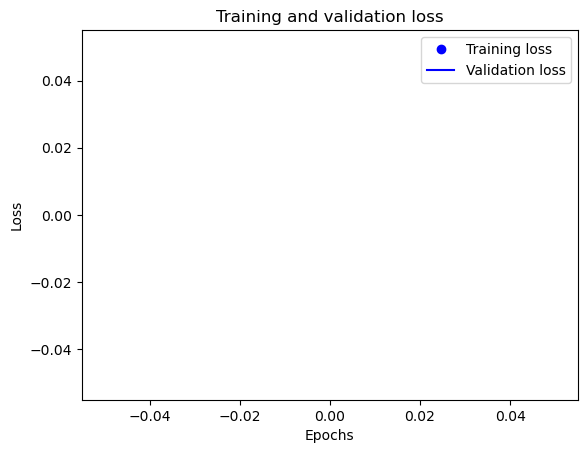

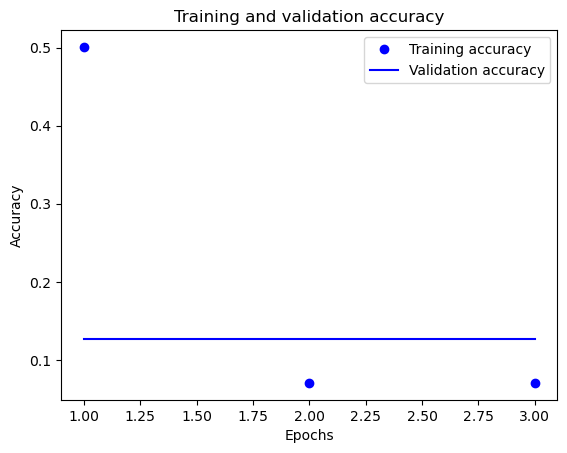

In [33]:
plot_history(history)

## Model #2 Summary: 

the test accuracy is less than half of model 1 even after  i doubled the filters. The model was obviously flawed with loss values at NaN. 

## Model #3

For Model 3 - I want to address the loss=NaN and the Validation Accuracy being the same throughout testing. I've read that lowering the initial learning rate can help the loss=NaN, but the Adam optimizer provides learning rates that adapt based on the model performance. I'm also going to try changing the shuffle to True to see if that allows some difference in the Validation Accuracy.

I'm going to change the filters back to lower and increase the patience so that it doesnt stop as soon and increase the batch size a little since - below says Adam works better on larger batch sizes. Memory will prohibit me from going too large. 

Taken from Best Practices for Using Adam Optimization:

Use Default Hyperparameters: In most cases, the default hyperparameters for Adam optimization (beta1=0.9, beta2=0.999, epsilon=1e-8) work well and do not need to be tuned.
Monitor Learning Rate: It can be helpful to monitor the learning rate during training to ensure that it is not too high or too low. A good rule of thumb is to set the initial learning rate to a small value and then gradually increase it until convergence.
Regularization: Adam optimization can benefit from regularization techniques like weight decay or dropout to prevent overfitting.
Batch Size: The batch size can have an impact on the performance of Adam optimization. In general, larger batch sizes tend to work better with Adam optimization compared to other optimization algorithms (Kumar, 2023).

In [34]:
def CNNLSTM_model3():

    backend.clear_session()

    model = Sequential()

    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='relu', data_format='channels_last', recurrent_dropout=0.2,
                         return_sequences=True, input_shape=(sequence_length, image_height, image_width, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2))) # or Batch normalization!

    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='relu', data_format='channels_last',
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(9, activation='softmax'))

    model.summary()

    return model


In [35]:
model = CNNLSTM_model3()

print('Model Created Successfully!')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 30, 222, 222, 4)   1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 30, 111, 111, 4)  0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 30, 111, 111, 4)  0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 30, 109, 109, 8)   3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 30, 55, 55, 8)    0         
 3D)                                                             
                                                        

Changed patience back to 6 to give it more time, shuffle changed to True to get rid of the NaNs, batch size of 6 to help the Adam optimizer. 

In [36]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 6)

model.compile(loss= 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

history = model.fit(x = features1, y= one_hot_encoded_labels1, epochs = 20,
                    batch_size = 6, shuffle = True, validation_data = (features2, one_hot_encoded_labels2),
                    callbacks = [early_stopping_callback])


Epoch 1/20
86/86 [==============================] - 1069s 12s/step - loss: 1413.2125 - accuracy: 0.1526 - val_loss: 10493.7412 - val_accuracy: 0.0952
Epoch 2/20
86/86 [==============================] - 1075s 13s/step - loss: 643.4891 - accuracy: 0.1624 - val_loss: 11211.5674 - val_accuracy: 0.0952
Epoch 3/20
86/86 [==============================] - 1050s 12s/step - loss: 548.9360 - accuracy: 0.1194 - val_loss: 10129.1162 - val_accuracy: 0.0952
Epoch 4/20
86/86 [==============================] - 1064s 12s/step - loss: 780.3030 - accuracy: 0.1566 - val_loss: 12474.3027 - val_accuracy: 0.2063
Epoch 5/20
86/86 [==============================] - 1067s 12s/step - loss: 785.8892 - accuracy: 0.1683 - val_loss: 6973.1011 - val_accuracy: 0.2063
Epoch 6/20
86/86 [==============================] - 1036s 12s/step - loss: 1123.6168 - accuracy: 0.1585 - val_loss: 9949.0098 - val_accuracy: 0.2063
Epoch 7/20
86/86 [==============================] - 1058s 12s/step - loss: 1601.6577 - accuracy: 0.1213 - 

In [37]:
test_loss, test_acc =model.evaluate(x = features3, y = one_hot_encoded_labels3, verbose=1) 


3/3 [==============================] - 31s 9s/step - loss: 14771.6943 - accuracy: 0.0897


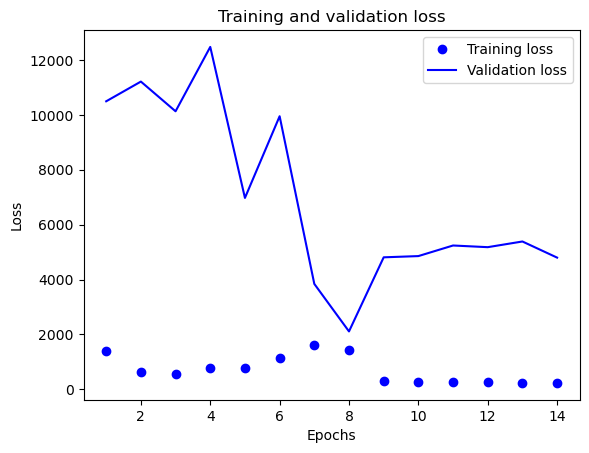

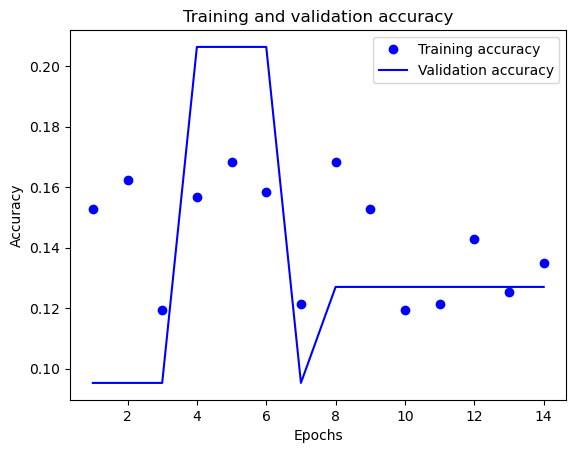

In [38]:
plot_history(history)

## Model #3 Summary:

So this model is still at 8% test accuracy. The accuracy plot looks like the validation line is showing some signs of following the training accuracy dots, but still not an acceptable accuracy. 

## Model #4:

For the 4th model, I'm going to switch to Batch Normalization instead of only Dropout. With Dropout, I may need to add more filters to each layer to make it useful. Batch Normalization can correct some of the jumpiness in the training, hopefully. 

https://www.kaggle.com/code/ryanholbrook/dropout-and-batch-normalization

In [28]:
def CNNLSTM_model4():

    backend.clear_session()

    model = Sequential()

    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='relu', data_format='channels_last', recurrent_dropout=0.2,
                         return_sequences=True, input_shape=(sequence_length, image_height, image_width, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(BatchNormalization())

    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='relu', data_format='channels_last',
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(Dropout(.2))

    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='relu', data_format='channels_last',
                        recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(Dropout(.2))


    model.add(Flatten())

    model.add(Dense(9, activation='softmax'))

    model.summary()

    return model


In [29]:
model = CNNLSTM_model4()

print('Model Created Successfully!')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 30, 222, 222, 8)   3200      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 30, 111, 111, 8)  0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 30, 111, 111, 8)  32        
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 30, 109, 109, 16)  13888     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 30, 55, 55, 16)   0         
 3D)                                                             
                                                        

In [30]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5)

model.compile(loss= 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

history = model.fit(x = features1, y= one_hot_encoded_labels1, epochs = 20,
                    batch_size = 6, shuffle = True, validation_data = (features2, one_hot_encoded_labels2),
                    callbacks = [early_stopping_callback])


Epoch 1/20
25/25 [==============================] - 630s 25s/step - loss: 7.4028 - accuracy: 0.2027 - val_loss: 1.8382 - val_accuracy: 0.1875
Epoch 2/20
25/25 [==============================] - 621s 25s/step - loss: 1.7967 - accuracy: 0.1689 - val_loss: 1.7927 - val_accuracy: 0.1875
Epoch 3/20
25/25 [==============================] - 626s 25s/step - loss: 1.7915 - accuracy: 0.1689 - val_loss: 1.7912 - val_accuracy: 0.1875
Epoch 4/20
25/25 [==============================] - 629s 25s/step - loss: 1.7920 - accuracy: 0.1689 - val_loss: 1.7909 - val_accuracy: 0.1875
Epoch 5/20
25/25 [==============================] - 632s 25s/step - loss: 1.7924 - accuracy: 0.1419 - val_loss: 1.7955 - val_accuracy: 0.1875
Epoch 6/20
25/25 [==============================] - 653s 26s/step - loss: 1.7919 - accuracy: 0.1757 - val_loss: 1.7925 - val_accuracy: 0.1875
Epoch 7/20
25/25 [==============================] - 630s 25s/step - loss: 1.7923 - accuracy: 0.1689 - val_loss: 1.7901 - val_accuracy: 0.1875
Epoch 

In [31]:
test_loss, test_acc =model.evaluate(x = features3, y = one_hot_encoded_labels3, verbose=1) 


3/3 [==============================] - 59s 16s/step - loss: 1.7879 - accuracy: 0.1875


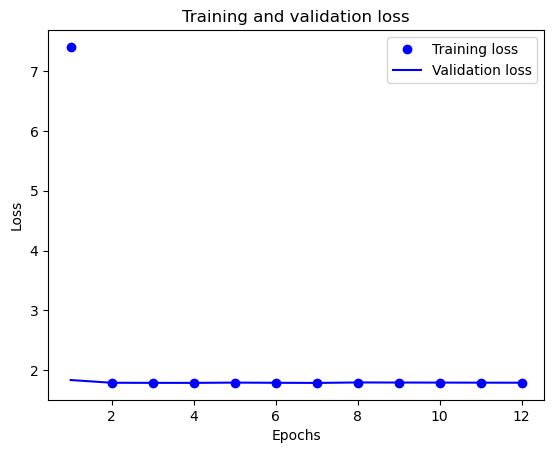

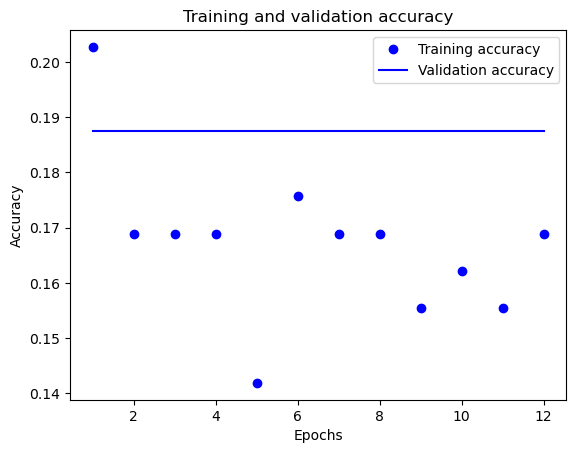

In [32]:
plot_history(history)

## Model #4 

The test accuracy jumped to 18% which has been the highest so far. 

## Model #5

Next, I want to spend a lot of time/epochs seeing if i can improve the accuracy. I'm hoping that using model 4 as a base will be better with the added batch norm and dropout. I will try to run this with 150 epochs and increase early stopping to 15 to give it longer to reach a higher accuracy while not wasting too much time, and turn back on restore best weights. I want to see if this model is capable of overfitting the training data. 

In [23]:
def CNNLSTM_model5():

    backend.clear_session()

    model = Sequential()

    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='relu', data_format='channels_last', recurrent_dropout=0.2,
                         return_sequences=True, input_shape=(sequence_length, image_height, image_width, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(BatchNormalization())

    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='relu', data_format='channels_last',
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(Dropout(.2))

    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='relu', data_format='channels_last',
                        recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(Dropout(.2))


    model.add(Flatten())

    model.add(Dense(9, activation='softmax'))

    model.summary()

    return model



In [24]:
model = CNNLSTM_model5()

print('Model Created Successfully!')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 30, 222, 222, 8)   3200      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 30, 111, 111, 8)  0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 30, 111, 111, 8)  32        
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 30, 109, 109, 16)  13888     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 30, 55, 55, 16)   0         
 3D)                                                             
                                                        

In [25]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, restore_best_weights=True)

model.compile(loss= 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

history = model.fit(x = features1, y= one_hot_encoded_labels1, epochs = 150,
                    batch_size = 6, shuffle = True, validation_data = (features2, one_hot_encoded_labels2),
                    callbacks = [early_stopping_callback])


Epoch 1/150
86/86 [==============================] - 2147s 25s/step - loss: 2.5772 - accuracy: 0.1820 - val_loss: 4.2674 - val_accuracy: 0.2063
Epoch 2/150
86/86 [==============================] - 2101s 24s/step - loss: 2.1119 - accuracy: 0.2250 - val_loss: 4.0278 - val_accuracy: 0.2063
Epoch 3/150
86/86 [==============================] - 2041s 24s/step - loss: 2.1549 - accuracy: 0.2368 - val_loss: 2.1596 - val_accuracy: 0.2063
Epoch 4/150
86/86 [==============================] - 2057s 24s/step - loss: 2.1112 - accuracy: 0.2407 - val_loss: 2.1263 - val_accuracy: 0.2063
Epoch 5/150
86/86 [==============================] - 2117s 25s/step - loss: 2.1046 - accuracy: 0.2505 - val_loss: 2.1152 - val_accuracy: 0.2063
Epoch 6/150
86/86 [==============================] - 2075s 24s/step - loss: 2.1154 - accuracy: 0.2505 - val_loss: 2.1467 - val_accuracy: 0.2063
Epoch 7/150
86/86 [==============================] - 2049s 24s/step - loss: 2.0950 - accuracy: 0.2485 - val_loss: 2.1199 - val_accuracy:

In [26]:
test_loss, test_acc =model.evaluate(x = features3, y = one_hot_encoded_labels3, steps = 30, verbose=1) 


30/30 [==============================] - 52s 2s/step - loss: 2.2066 - accuracy: 0.2051


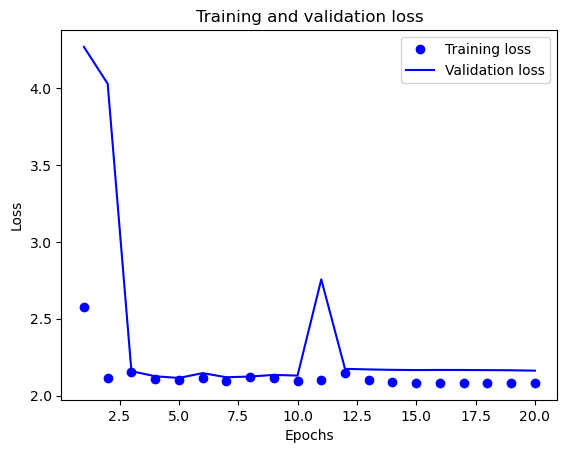

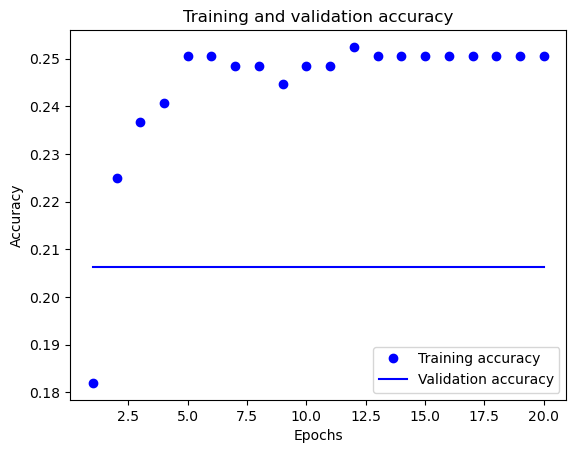

In [27]:
plot_history(history)

I tried to overfit the model. looks like it started to work on the training data, but still did not produce decent accuracy. I'm not sure the accuracy could get any better with the frames in their current state. I'll discuss above my assumptions on why this is. 

In [72]:
from sklearn.metrics import classification_report, confusion_matrix

test_integer_labels = np.argmax(one_hot_encoded_labels3, axis=1)

# Get model predictions
predictions = model.predict(features3)

# If your predictions are one-hot encoded, convert them to integer labels
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(test_integer_labels, predicted_labels)

print(cm)

3/3 [==============================] - 63s 17s/step
[[ 0  0  0  0  0  0  0  7  0]
 [ 0  0  0  0  0  0  0 11  0]
 [ 0  0  0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0  0 16  0]
 [ 0  0  0  0  0  0  0  7  0]]


It looks like the last model was just predicting everything as label 9 - Stealing. This isn't logical because the frames available from that label were among the lowest. A single label being prediction usually comes from an overwhelmingly skewed dataset, with  mostly videos of label 9. But this would explain the validation accuracy being the same for each epoch in each model. 

In [74]:
print(classification_report(test_integer_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         6
           7       0.21      1.00      0.34        16
           8       0.00      0.00      0.00         7

    accuracy                           0.21        78
   macro avg       0.02      0.11      0.04        78
weighted avg       0.04      0.21      0.07        78



/opt/anaconda3/envs/msds-686/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/msds-686/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/msds-686/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-------

### References:

Brownlee, J. (2020). How to Tune LSTM Hyperparameters with Keras for Time Series Forecasting. https://machinelearningmastery.com/tune-lstm-hyperparameters-keras-time-series-forecasting/

Cosgrove, E. (2019, December 6). One billion surveillance cameras will be watching around the world in 2021, a new study says. CNBC. https://www.cnbc.com/2019/12/06/one-billion-surveillance-cameras-will-be-watching-globally-in-2021.html

Kumar, K. (2023, March 29). Getting to know adam optimization: A comprehensive guide. https://www.linkedin.com/pulse/getting-know-adam-optimization-comprehensive-guide-kiran-kumar

Melore, C. (2020, September 24). Average American recorded by security cameras 238 times each week. Study Finds. https://studyfinds.org/americans-security-cameras-study/

Pro-Vigil. (2022, March 24). 15% of businesses never check their camera footage – and that’s a problem. Pro-Vigil Video Surveillance. https://pro-vigil.com/blog/15-of-businesses-never-check-their-camera-footage-and-thats-a-problem/

Xavier, A. (2019, April 22). An introduction to ConvLSTM. Neuronio. https://medium.com/neuronio/an-introduction-to-convlstm-55c9025563a7


#### Dataset obtained from the University of Central Florida's Center for Research in Computer Vision: 
https://www.crcv.ucf.edu/projects/real-world/
